Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


First reload the data we generated in `1_notmnist.ipynb`.

In [3]:
#pickle_file = 'notMNIST.pickle'
pickle_file = 'notMNIST_noDupNorOvlp.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (438047, 28, 28) (438047,)
Validation set (15586, 28, 28) (15586,)
Test set (13645, 28, 28) (13645,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [4]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (438047, 784) (438047, 10)
Validation set (15586, 784) (15586, 10)
Test set (13645, 784) (13645, 10)


In [5]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

##### Model 1: 
Logistic regression with SGD

Set-up Model:

In [12]:
batch_size = 128

_BETA_REGUL = 5e-4 #5e-4 Based on 3_mnist_from_scratch.ipynb. May change.

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels, logits=logits))
    
  #The question here is: Do we also want to take into account biases fro regularization?
  #"applying weight decay to the bias units usually makes only a small difference to the final network"
  # L2 regularization for the fully connected parameters.
  l2_regularization = (tf.nn.l2_loss(weights) + tf.nn.l2_loss(biases) )
  #l2_regularization = tf.nn.l2_loss(weights)
  loss += _BETA_REGUL * l2_regularization
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Run the model:

In [13]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 16.104467
Minibatch accuracy: 12.5%
Validation accuracy: 15.0%
Minibatch loss at step 500: 2.347745
Minibatch accuracy: 77.3%
Validation accuracy: 72.9%
Minibatch loss at step 1000: 1.452825
Minibatch accuracy: 84.4%
Validation accuracy: 74.1%
Minibatch loss at step 1500: 1.589714
Minibatch accuracy: 72.7%
Validation accuracy: 75.5%
Minibatch loss at step 2000: 1.175524
Minibatch accuracy: 76.6%
Validation accuracy: 76.3%
Minibatch loss at step 2500: 0.860617
Minibatch accuracy: 80.5%
Validation accuracy: 77.9%
Minibatch loss at step 3000: 0.580042
Minibatch accuracy: 89.1%
Validation accuracy: 78.3%
Test accuracy: 85.7%


Compared to assignment 2 (Logistic regression SGD at iteration 3000:

*Ass 2 no regu: Minibatch loss at step 3000: 0.578054
Minibatch accuracy: 86.7%
Validation accuracy: 76.1%
Test accuracy: 83.6%*

*Last L2 Regul only weights beta 5e-4: Minibatch loss at step 3000: 0.580042
Minibatch accuracy: 89.1%
Validation accuracy: 78.3%
Test accuracy: 85.7%*



##### Model 2:  
1-hidden layer neural network with rectified linear units nn.relu() and 1024 hidden nodes. 

In [8]:
batch_size = 128

hidden1_nodes = 1024

_BETA_REGUL = 5e-4 #5e-4 Based on 3_mnist_from_scratch.ipynb. May change.

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = {
    'h1': tf.Variable( tf.truncated_normal([image_size * image_size, hidden1_nodes]) ),
    'out': tf.Variable( tf.truncated_normal([hidden1_nodes, num_labels]) )
  }
  biases = {
    'b1': tf.Variable(tf.zeros([hidden1_nodes])),
    'out': tf.Variable(tf.zeros([num_labels]))
  }
  
  # Create neural network model:
  # Hidden fully connected layer with 256 neurons.
  layer_1 = tf.add(tf.matmul(tf_train_dataset, weights['h1']) , biases['b1'])
  #Output layer applying relu to hiden layer
  logits_out = tf.matmul( tf.nn.relu(layer_1), weights['out']) + biases['out']
  #Define loss
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits_out))
    
  # L2 regularization for the fully connected parameters.
  l2_regularization = (tf.nn.l2_loss(weights['h1']) + tf.nn.l2_loss(biases['b1'])
                      + tf.nn.l2_loss(weights['out']) + tf.nn.l2_loss(biases['out']))
  #l2_regularization = tf.nn.l2_loss(weights)
  loss += _BETA_REGUL * l2_regularization

    ##Needed to evaluate test and validation datasets
  test_layer_1 = tf.matmul(tf_test_dataset, weights['h1']) + biases['b1']
  test_logits_out = tf.matmul( tf.nn.relu(test_layer_1), weights['out']) + biases['out']
    
  valid_layer_1 = tf.add(tf.matmul(tf_valid_dataset, weights['h1']) , biases['b1'])
  valid_logits_out = tf.matmul( tf.nn.relu(valid_layer_1), weights['out']) + biases['out']
  
  # Optimizer.
  #optimizer = tf.train.AdagradOptimizer(0.5).minimize(loss)
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits_out)
  valid_prediction = tf.nn.softmax(valid_logits_out)
  test_prediction = tf.nn.softmax(test_logits_out)

Let's Run the model: 

Initialized
Minibatch loss at step 0: 535.250305
Minibatch accuracy: 3.1%
Validation accuracy: 25.0%
Minibatch loss at step 500: 128.788483
Minibatch accuracy: 78.9%
Validation accuracy: 77.1%
Minibatch loss at step 1000: 95.687538
Minibatch accuracy: 87.5%
Validation accuracy: 77.0%
Minibatch loss at step 1500: 73.943321
Minibatch accuracy: 80.5%
Validation accuracy: 77.4%
Minibatch loss at step 2000: 58.023598
Minibatch accuracy: 81.2%
Validation accuracy: 78.3%
Test accuracy: 85.6%


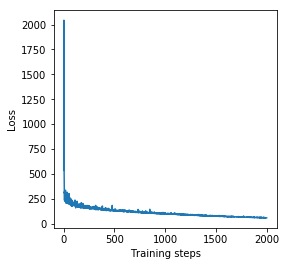

In [20]:
num_steps = 5001

losses = []

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    losses.append(l)
    
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))


# Show the loss over time.
plt.figure(figsize=(4,4))
plt.plot(range(0, num_steps), losses)
plt.ylabel("Loss")
plt.xlabel("Training steps")
plt.show()

Compared to assignment 2 (Logistic regression SGD at iteration 3000:

*Ass 2 NN: Minibatch loss at step 5000: 4.587700
Minibatch accuracy: 78.1%
Validation accuracy: 79.6%
Test accuracy: 86.6%*

*Last L2 Regul only weights and bias beta 5e-4: Minibatch loss at step 5000: 12.971046
Minibatch accuracy: 82.0%
Validation accuracy: 84.4%
Test accuracy: 90.5%
*

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

To run a few batches we will try by only running a small subset of batches. So batch size is the same, but we will only train with a small subset of batches (no going through the whole training dataset.

We will implement this by making the offset a random number between 0 and 10. Only first 10 batches on the data training set are used for training.

Let´s run the model Using the Setup of previous exercise.

Initialized
Minibatch loss at step 0: 527.359375
Minibatch accuracy: 5.5%
Validation accuracy: 36.1%
Minibatch loss at step 500: 127.361511
Minibatch accuracy: 99.2%
Validation accuracy: 75.0%
Minibatch loss at step 1000: 95.485588
Minibatch accuracy: 100.0%
Validation accuracy: 75.6%
Minibatch loss at step 1500: 74.362022
Minibatch accuracy: 100.0%
Validation accuracy: 75.6%
Minibatch loss at step 2000: 57.911427
Minibatch accuracy: 100.0%
Validation accuracy: 75.6%
Minibatch loss at step 2500: 45.099991
Minibatch accuracy: 100.0%
Validation accuracy: 75.6%
Minibatch loss at step 3000: 35.122944
Minibatch accuracy: 100.0%
Validation accuracy: 75.6%
Minibatch loss at step 3500: 27.352951
Minibatch accuracy: 100.0%
Validation accuracy: 75.7%
Minibatch loss at step 4000: 21.302094
Minibatch accuracy: 100.0%
Validation accuracy: 75.8%
Minibatch loss at step 4500: 16.589764
Minibatch accuracy: 100.0%
Validation accuracy: 75.8%
Minibatch loss at step 5000: 12.920185
Minibatch accuracy: 100.

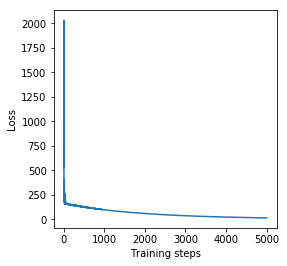

In [18]:

import matplotlib.pyplot as plt

num_steps = 5001

losses = []

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the first 10 subsetes of 128 entries in dataset.
    offset = batch_size * np.random.choice(10)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    losses.append(l)
    
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))


# Show the loss over time.
plt.figure(figsize=(4,4))
plt.plot(range(0, num_steps), losses)
plt.ylabel("Loss")
plt.xlabel("Training steps")
plt.show()

As we can see, The Minibatch accuracy is 100% (Actually this is like training with a smaller dataset).
However, Validation and test accuracy are lower.

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

Note that nn.dropout is only applied in train_layer_1. 

We will apply a probability of 0.5 to keep/dropout an activation (values that go from one layer to the next).

In [19]:
batch_size = 128

hidden1_nodes = 1024

_BETA_REGUL = 5e-4 #5e-4 Based on 3_mnist_from_scratch.ipynb. May change.

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = {
    'h1': tf.Variable( tf.truncated_normal([image_size * image_size, hidden1_nodes]) ),
    'out': tf.Variable( tf.truncated_normal([hidden1_nodes, num_labels]) )
  }
  biases = {
    'b1': tf.Variable(tf.zeros([hidden1_nodes])),
    'out': tf.Variable(tf.zeros([num_labels]))
  }
  
  # Create neural network model:
  # Hidden fully connected layer with 256 neurons.
  train_layer_1 = tf.add(tf.matmul(tf_train_dataset, weights['h1']) , biases['b1'])
  train_layer_1 = tf.nn.dropout(train_layer_1, 0.5)
  #Output layer applying relu to hiden layer
  logits_out = tf.matmul( tf.nn.relu(train_layer_1), weights['out']) + biases['out']
  #Define loss
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits_out))
    
  # L2 regularization for the fully connected parameters.
  l2_regularization = (tf.nn.l2_loss(weights['h1']) + tf.nn.l2_loss(biases['b1'])
                      + tf.nn.l2_loss(weights['out']) + tf.nn.l2_loss(biases['out']))
  #l2_regularization = tf.nn.l2_loss(weights)
  loss += _BETA_REGUL * l2_regularization

    ##Needed to evaluate test and validation datasets
  test_layer_1 = tf.matmul(tf_test_dataset, weights['h1']) + biases['b1']
  test_logits_out = tf.matmul( tf.nn.relu(test_layer_1), weights['out']) + biases['out']
    
  valid_layer_1 = tf.add(tf.matmul(tf_valid_dataset, weights['h1']) , biases['b1'])
  valid_logits_out = tf.matmul( tf.nn.relu(valid_layer_1), weights['out']) + biases['out']
  
  # Optimizer.
  #optimizer = tf.train.AdagradOptimizer(0.5).minimize(loss)
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits_out)
  valid_prediction = tf.nn.softmax(valid_logits_out)
  test_prediction = tf.nn.softmax(test_logits_out)

Let's run the Model.

Initialized
Minibatch loss at step 0: 647.199707
Minibatch accuracy: 15.6%
Validation accuracy: 30.8%
Minibatch loss at step 500: 141.209442
Minibatch accuracy: 71.9%
Validation accuracy: 76.5%
Minibatch loss at step 1000: 98.687836
Minibatch accuracy: 81.2%
Validation accuracy: 75.1%
Minibatch loss at step 1500: 78.025322
Minibatch accuracy: 68.8%
Validation accuracy: 76.7%
Minibatch loss at step 2000: 62.269276
Minibatch accuracy: 68.8%
Validation accuracy: 77.4%
Minibatch loss at step 2500: 45.906364
Minibatch accuracy: 72.7%
Validation accuracy: 78.5%
Minibatch loss at step 3000: 34.820324
Minibatch accuracy: 81.2%
Validation accuracy: 78.7%
Minibatch loss at step 3500: 27.925144
Minibatch accuracy: 73.4%
Validation accuracy: 80.3%
Minibatch loss at step 4000: 21.562328
Minibatch accuracy: 77.3%
Validation accuracy: 80.6%
Minibatch loss at step 4500: 16.728735
Minibatch accuracy: 78.1%
Validation accuracy: 82.4%
Minibatch loss at step 5000: 13.389703
Minibatch accuracy: 80.5%
Valid

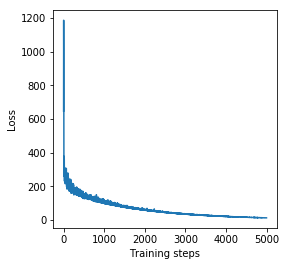

In [20]:
num_steps = 5001

losses = []

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    losses.append(l)
    
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))


# Show the loss over time.
plt.figure(figsize=(4,4))
plt.plot(range(0, num_steps), losses)
plt.ylabel("Loss")
plt.xlabel("Training steps")
plt.show()

Dropout technique seems to improve the model. Test accuray is now aroun 89% when for Problem 1 was around 85%.

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


##### 4.1. Set Up the Model
###### First Approach 
Multilayer Neural Network with 4 hidden layers of same number of neurons each. 

Weights initialized with deviation square root of (2 / input activations to layer)

RELU function for each layer activations.

Dropout technique at each layer activations. Only during training.

L2 Regulariation including also biases.

Dynamic learning rate.




In [98]:
batch_size = 128

image_size = 28
num_labels = 10

num_steps = 5001

hidden_layer_nodes = {
    'h1' : 1024,
    'h2' : 1024,
    'h3' : 512,
    'h4' : 512 
}

_BETA_REGUL = 5e-4 #5e-4 Based on 3_mnist_from_scratch.ipynb. May change.

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = {
    'h1': tf.Variable( tf.truncated_normal([image_size * image_size, hidden_layer_nodes['h1'] ] , 
                                           stddev = np.sqrt(2.0 / (image_size * image_size))) ),
    'h2': tf.Variable( tf.truncated_normal([hidden_layer_nodes['h1'], hidden_layer_nodes['h2'] ] , 
                                           stddev = np.sqrt(2.0 / hidden_layer_nodes['h1'] )) ),
    'h3': tf.Variable( tf.truncated_normal([hidden_layer_nodes['h2'], hidden_layer_nodes['h3'] ] , 
                                           stddev = np.sqrt(2.0 / hidden_layer_nodes['h2'] )) ),
    'h4': tf.Variable( tf.truncated_normal([hidden_layer_nodes['h3'], hidden_layer_nodes['h4'] ] , 
                                           stddev = np.sqrt(2.0 / hidden_layer_nodes['h3'] )) ),
    'out': tf.Variable( tf.truncated_normal([hidden_layer_nodes['h4'], num_labels] , 
                                            stddev= np.sqrt(2.0 / hidden_layer_nodes['h4'] )) ),
  }
  biases = {
    'b1': tf.Variable(tf.zeros([hidden_layer_nodes['h1'] ])),
    'b2': tf.Variable(tf.zeros([hidden_layer_nodes['h2'] ])),
    'b3': tf.Variable(tf.zeros([hidden_layer_nodes['h3'] ])),
    'b4': tf.Variable(tf.zeros([hidden_layer_nodes['h4'] ])),
    'out': tf.Variable(tf.zeros([num_labels]))
  }
  
  # Create neural network model:
  train_layer_1 = tf.add(tf.matmul(tf_train_dataset, weights['h1']) , biases['b1'])
  train_layer_1 = tf.nn.dropout(tf.nn.relu(train_layer_1), 0.5)
    
  train_layer_2 = tf.add(tf.matmul(train_layer_1, weights['h2']) , biases['b2'])
  train_layer_2 = tf.nn.dropout(tf.nn.relu(train_layer_2), 0.5)
    
  train_layer_3 = tf.add(tf.matmul(train_layer_2, weights['h3']) , biases['b3'])
  train_layer_3 = tf.nn.dropout(tf.nn.relu(train_layer_3), 0.5)
    
  train_layer_4 = tf.add(tf.matmul(train_layer_3, weights['h4']) , biases['b4'])
  train_layer_4 = tf.nn.dropout(tf.nn.relu(train_layer_4), 0.5)
    
  logits_out = tf.add(tf.matmul( train_layer_4, weights['out']) , biases['out'])
  #Define loss
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels, logits=logits_out))
    
  # L2 regularization for the fully connected parameters.
  l2_regul = (tf.nn.l2_loss(weights['h1']) + tf.nn.l2_loss(biases['b1'])
                       + tf.nn.l2_loss(weights['h2']) + tf.nn.l2_loss(biases['b2'])
                       + tf.nn.l2_loss(weights['h3']) + tf.nn.l2_loss(biases['b3'])
                       + tf.nn.l2_loss(weights['h4']) + tf.nn.l2_loss(biases['b4'])
                       + tf.nn.l2_loss(weights['out']) + tf.nn.l2_loss(biases['out']) )
    
  loss += _BETA_REGUL * l2_regul
  
  # Optimizer. Exponential decay of learning rate
  #optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  global_step = tf.Variable(0)  # count the number of steps taken.
  learning_rate = tf.train.exponential_decay(0.5, # Base learning rate. Start big to learn fast at the beginning
                                             global_step * batch_size,
                                             tf_train_labels.shape[0],# Decay step.
                                             0.97,                # Decay rate.
                                             staircase=True)

  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  #optimizer = tf.train.AdadeltaOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
  

  ##Needed to evaluate test and validation datasets
  test_layer_1 = tf.add(tf.matmul(tf_test_dataset, weights['h1']) , biases['b1'])
  test_layer_2 = tf.add(tf.matmul(tf.nn.relu(test_layer_1), weights['h2']) , biases['b2'])
  test_layer_3 = tf.add(tf.matmul(tf.nn.relu(test_layer_2), weights['h3']) , biases['b3'])
  test_layer_4 = tf.add(tf.matmul(tf.nn.relu(test_layer_3), weights['h4']) , biases['b4'])
  test_logits_out = tf.matmul( tf.nn.relu(test_layer_4), weights['out']) + biases['out']
    
  valid_layer_1 = tf.add(tf.matmul(tf_valid_dataset, weights['h1']) , biases['b1'])
  valid_layer_2 = tf.add(tf.matmul(tf.nn.relu(valid_layer_1), weights['h2']) , biases['b2'])
  valid_layer_3 = tf.add(tf.matmul(tf.nn.relu(valid_layer_2), weights['h3']) , biases['b3'])
  valid_layer_4 = tf.add(tf.matmul(tf.nn.relu(valid_layer_3), weights['h4']) , biases['b4'])
  valid_logits_out = tf.matmul( tf.nn.relu(valid_layer_4), weights['out']) + biases['out']

  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits_out)
  valid_prediction = tf.nn.softmax(valid_logits_out)
  test_prediction = tf.nn.softmax(test_logits_out)

Let´s run the Model:

Initialized
Iteration 0 ... step 1 loss 4.23354959488
Minibatch loss at step 0: 4.233550
Minibatch accuracy: 10.9%
Validation accuracy: 10.2%
Iteration 1 ... step 2 loss 6.9909029007
Iteration 2 ... step 3 loss 5.19958209991
Iteration 3 ... step 4 loss 4.08319854736
Iteration 4 ... step 5 loss 3.49902033806
Iteration 5 ... step 6 loss 3.52801561356
Iteration 6 ... step 7 loss 3.55355930328
Iteration 7 ... step 8 loss 3.47751283646
Iteration 8 ... step 9 loss 3.42500209808
Iteration 9 ... step 10 loss 3.38857245445
Iteration 10 ... step 11 loss 3.44027280807
Iteration 11 ... step 12 loss 3.41366839409
Iteration 12 ... step 13 loss 3.35109472275
Iteration 13 ... step 14 loss 3.27803468704
Iteration 14 ... step 15 loss 3.33655548096
Iteration 15 ... step 16 loss 3.31098842621
Iteration 16 ... step 17 loss 3.23417854309
Iteration 17 ... step 18 loss 3.12282323837
Iteration 18 ... step 19 loss 3.10642838478
Iteration 19 ... step 20 loss 3.05146408081
Iteration 20 ... step 21 loss 3.05306291

Iteration 183 ... step 184 loss 2.07374048233
Iteration 184 ... step 185 loss 2.25898694992
Iteration 185 ... step 186 loss 2.08748817444
Iteration 186 ... step 187 loss 2.14061641693
Iteration 187 ... step 188 loss 2.21252989769
Iteration 188 ... step 189 loss 2.3218626976
Iteration 189 ... step 190 loss 2.3483338356
Iteration 190 ... step 191 loss 2.33314323425
Iteration 191 ... step 192 loss 2.24686551094
Iteration 192 ... step 193 loss 2.18998670578
Iteration 193 ... step 194 loss 2.20352292061
Iteration 194 ... step 195 loss 2.40285038948
Iteration 195 ... step 196 loss 2.12371706963
Iteration 196 ... step 197 loss 2.15352058411
Iteration 197 ... step 198 loss 2.35987305641
Iteration 198 ... step 199 loss 2.25082826614
Iteration 199 ... step 200 loss 2.22130584717
Iteration 200 ... step 201 loss 2.35059714317
Iteration 201 ... step 202 loss 2.17579174042
Iteration 202 ... step 203 loss 2.3226621151
Iteration 203 ... step 204 loss 2.19273519516
Iteration 204 ... step 205 loss 2.342

Iteration 363 ... step 364 loss 2.18031167984
Iteration 364 ... step 365 loss 2.29192638397
Iteration 365 ... step 366 loss 2.24346065521
Iteration 366 ... step 367 loss 2.35952758789
Iteration 367 ... step 368 loss 2.18191003799
Iteration 368 ... step 369 loss 2.21057033539
Iteration 369 ... step 370 loss 2.34536314011
Iteration 370 ... step 371 loss 2.39218378067
Iteration 371 ... step 372 loss 2.33766508102
Iteration 372 ... step 373 loss 2.12057089806
Iteration 373 ... step 374 loss 2.2064602375
Iteration 374 ... step 375 loss 2.30845975876
Iteration 375 ... step 376 loss 2.24492788315
Iteration 376 ... step 377 loss 2.16488695145
Iteration 377 ... step 378 loss 2.33229160309
Iteration 378 ... step 379 loss 2.28449821472
Iteration 379 ... step 380 loss 2.44454097748
Iteration 380 ... step 381 loss 2.52373409271
Iteration 381 ... step 382 loss 2.38977622986
Iteration 382 ... step 383 loss 2.39851093292
Iteration 383 ... step 384 loss 2.3828253746
Iteration 384 ... step 385 loss 2.28

Iteration 541 ... step 542 loss 2.44231319427
Iteration 542 ... step 543 loss 2.18038678169
Iteration 543 ... step 544 loss 2.03113412857
Iteration 544 ... step 545 loss 2.28576374054
Iteration 545 ... step 546 loss 2.37753295898
Iteration 546 ... step 547 loss 2.16230916977
Iteration 547 ... step 548 loss 2.12164115906
Iteration 548 ... step 549 loss 2.47044610977
Iteration 549 ... step 550 loss 2.29103326797
Iteration 550 ... step 551 loss 2.26095247269
Iteration 551 ... step 552 loss 2.26705932617
Iteration 552 ... step 553 loss 2.27928209305
Iteration 553 ... step 554 loss 2.17314600945
Iteration 554 ... step 555 loss 2.38998508453
Iteration 555 ... step 556 loss 2.20842909813
Iteration 556 ... step 557 loss 2.28488063812
Iteration 557 ... step 558 loss 2.22193932533
Iteration 558 ... step 559 loss 2.29133462906
Iteration 559 ... step 560 loss 2.3838596344
Iteration 560 ... step 561 loss 2.13636469841
Iteration 561 ... step 562 loss 2.30360794067
Iteration 562 ... step 563 loss 2.1

Iteration 720 ... step 721 loss 2.06093096733
Iteration 721 ... step 722 loss 2.15952515602
Iteration 722 ... step 723 loss 2.03179311752
Iteration 723 ... step 724 loss 2.37573862076
Iteration 724 ... step 725 loss 2.45591115952
Iteration 725 ... step 726 loss 2.39694547653
Iteration 726 ... step 727 loss 1.95225548744
Iteration 727 ... step 728 loss 2.12410354614
Iteration 728 ... step 729 loss 2.34713363647
Iteration 729 ... step 730 loss 2.23948144913
Iteration 730 ... step 731 loss 2.2108271122
Iteration 731 ... step 732 loss 2.23899364471
Iteration 732 ... step 733 loss 2.51820516586
Iteration 733 ... step 734 loss 2.28916573524
Iteration 734 ... step 735 loss 2.36692523956
Iteration 735 ... step 736 loss 2.14150524139
Iteration 736 ... step 737 loss 2.30721569061
Iteration 737 ... step 738 loss 2.30821323395
Iteration 738 ... step 739 loss 2.13242125511
Iteration 739 ... step 740 loss 2.24373888969
Iteration 740 ... step 741 loss 2.24763059616
Iteration 741 ... step 742 loss 2.3

Iteration 899 ... step 900 loss 2.04568910599
Iteration 900 ... step 901 loss 2.13445568085
Iteration 901 ... step 902 loss 2.33545875549
Iteration 902 ... step 903 loss 2.31231307983
Iteration 903 ... step 904 loss 2.25813484192
Iteration 904 ... step 905 loss 2.32230424881
Iteration 905 ... step 906 loss 2.3983335495
Iteration 906 ... step 907 loss 2.21435832977
Iteration 907 ... step 908 loss 2.17196178436
Iteration 908 ... step 909 loss 2.29711508751
Iteration 909 ... step 910 loss 2.24006700516
Iteration 910 ... step 911 loss 2.44505929947
Iteration 911 ... step 912 loss 2.1603076458
Iteration 912 ... step 913 loss 2.3604388237
Iteration 913 ... step 914 loss 2.20299959183
Iteration 914 ... step 915 loss 2.21742486954
Iteration 915 ... step 916 loss 2.17852473259
Iteration 916 ... step 917 loss 2.31054830551
Iteration 917 ... step 918 loss 2.21205425262
Iteration 918 ... step 919 loss 2.17439007759
Iteration 919 ... step 920 loss 2.20536708832
Iteration 920 ... step 921 loss 2.020

Iteration 1074 ... step 1075 loss 2.16362166405
Iteration 1075 ... step 1076 loss 2.29614210129
Iteration 1076 ... step 1077 loss 2.32750320435
Iteration 1077 ... step 1078 loss 2.38884854317
Iteration 1078 ... step 1079 loss 2.29060935974
Iteration 1079 ... step 1080 loss 2.32146453857
Iteration 1080 ... step 1081 loss 2.26704359055
Iteration 1081 ... step 1082 loss 2.20735144615
Iteration 1082 ... step 1083 loss 2.22499537468
Iteration 1083 ... step 1084 loss 2.34059095383
Iteration 1084 ... step 1085 loss 2.29912376404
Iteration 1085 ... step 1086 loss 2.10935020447
Iteration 1086 ... step 1087 loss 2.33197307587
Iteration 1087 ... step 1088 loss 2.26337909698
Iteration 1088 ... step 1089 loss 2.36064100266
Iteration 1089 ... step 1090 loss 2.43482017517
Iteration 1090 ... step 1091 loss 2.42672252655
Iteration 1091 ... step 1092 loss 2.35392618179
Iteration 1092 ... step 1093 loss 2.1119351387
Iteration 1093 ... step 1094 loss 2.13679170609
Iteration 1094 ... step 1095 loss 2.24467

Iteration 1247 ... step 1248 loss 2.19613647461
Iteration 1248 ... step 1249 loss 2.55565452576
Iteration 1249 ... step 1250 loss 2.18450784683
Iteration 1250 ... step 1251 loss 2.32734012604
Iteration 1251 ... step 1252 loss 2.13210391998
Iteration 1252 ... step 1253 loss 2.27593016624
Iteration 1253 ... step 1254 loss 2.30617713928
Iteration 1254 ... step 1255 loss 2.31864285469
Iteration 1255 ... step 1256 loss 2.2869925499
Iteration 1256 ... step 1257 loss 2.48539733887
Iteration 1257 ... step 1258 loss 2.39488577843
Iteration 1258 ... step 1259 loss 2.23161220551
Iteration 1259 ... step 1260 loss 2.29228973389
Iteration 1260 ... step 1261 loss 2.01138043404
Iteration 1261 ... step 1262 loss 1.98119986057
Iteration 1262 ... step 1263 loss 2.31374192238
Iteration 1263 ... step 1264 loss 2.29148817062
Iteration 1264 ... step 1265 loss 2.40335702896
Iteration 1265 ... step 1266 loss 2.36938476562
Iteration 1266 ... step 1267 loss 2.24142670631
Iteration 1267 ... step 1268 loss 2.32318

Iteration 1418 ... step 1419 loss 2.11975479126
Iteration 1419 ... step 1420 loss 2.25233650208
Iteration 1420 ... step 1421 loss 2.33711385727
Iteration 1421 ... step 1422 loss 2.24698734283
Iteration 1422 ... step 1423 loss 2.37077260017
Iteration 1423 ... step 1424 loss 2.22569274902
Iteration 1424 ... step 1425 loss 2.0754981041
Iteration 1425 ... step 1426 loss 2.11193442345
Iteration 1426 ... step 1427 loss 2.40028595924
Iteration 1427 ... step 1428 loss 2.0773434639
Iteration 1428 ... step 1429 loss 2.09838628769
Iteration 1429 ... step 1430 loss 2.10109472275
Iteration 1430 ... step 1431 loss 2.18511724472
Iteration 1431 ... step 1432 loss 2.01866579056
Iteration 1432 ... step 1433 loss 2.22542619705
Iteration 1433 ... step 1434 loss 2.16615915298
Iteration 1434 ... step 1435 loss 2.17537975311
Iteration 1435 ... step 1436 loss 2.05661821365
Iteration 1436 ... step 1437 loss 2.17289590836
Iteration 1437 ... step 1438 loss 2.31391096115
Iteration 1438 ... step 1439 loss 2.270207

Iteration 1589 ... step 1590 loss 2.15720319748
Iteration 1590 ... step 1591 loss 2.34645318985
Iteration 1591 ... step 1592 loss 1.97025740147
Iteration 1592 ... step 1593 loss 2.27169656754
Iteration 1593 ... step 1594 loss 2.26496100426
Iteration 1594 ... step 1595 loss 2.19305634499
Iteration 1595 ... step 1596 loss 2.08966159821
Iteration 1596 ... step 1597 loss 2.17739224434
Iteration 1597 ... step 1598 loss 2.41609859467
Iteration 1598 ... step 1599 loss 2.08195757866
Iteration 1599 ... step 1600 loss 2.32801055908
Iteration 1600 ... step 1601 loss 2.19943904877
Iteration 1601 ... step 1602 loss 2.44313454628
Iteration 1602 ... step 1603 loss 2.3197426796
Iteration 1603 ... step 1604 loss 2.21550440788
Iteration 1604 ... step 1605 loss 2.29719400406
Iteration 1605 ... step 1606 loss 2.38955330849
Iteration 1606 ... step 1607 loss 2.24503850937
Iteration 1607 ... step 1608 loss 2.22900867462
Iteration 1608 ... step 1609 loss 2.05180549622
Iteration 1609 ... step 1610 loss 2.09487

Iteration 1761 ... step 1762 loss 2.32683205605
Iteration 1762 ... step 1763 loss 2.12243080139
Iteration 1763 ... step 1764 loss 2.30359983444
Iteration 1764 ... step 1765 loss 1.97739386559
Iteration 1765 ... step 1766 loss 2.210501194
Iteration 1766 ... step 1767 loss 2.08643507957
Iteration 1767 ... step 1768 loss 2.14822292328
Iteration 1768 ... step 1769 loss 2.02947402
Iteration 1769 ... step 1770 loss 2.20211935043
Iteration 1770 ... step 1771 loss 2.33597946167
Iteration 1771 ... step 1772 loss 2.12094497681
Iteration 1772 ... step 1773 loss 2.17528247833
Iteration 1773 ... step 1774 loss 2.15475821495
Iteration 1774 ... step 1775 loss 2.2176861763
Iteration 1775 ... step 1776 loss 2.2089715004
Iteration 1776 ... step 1777 loss 2.38246774673
Iteration 1777 ... step 1778 loss 2.48072767258
Iteration 1778 ... step 1779 loss 2.07015252113
Iteration 1779 ... step 1780 loss 2.30237388611
Iteration 1780 ... step 1781 loss 2.17362236977
Iteration 1781 ... step 1782 loss 2.23944497108

Iteration 1933 ... step 1934 loss 2.29720449448
Iteration 1934 ... step 1935 loss 2.47972416878
Iteration 1935 ... step 1936 loss 2.19899368286
Iteration 1936 ... step 1937 loss 2.11017155647
Iteration 1937 ... step 1938 loss 2.36135292053
Iteration 1938 ... step 1939 loss 2.39602994919
Iteration 1939 ... step 1940 loss 2.20328712463
Iteration 1940 ... step 1941 loss 2.2251534462
Iteration 1941 ... step 1942 loss 2.16582298279
Iteration 1942 ... step 1943 loss 2.31855273247
Iteration 1943 ... step 1944 loss 2.40898227692
Iteration 1944 ... step 1945 loss 2.28827190399
Iteration 1945 ... step 1946 loss 2.13406682014
Iteration 1946 ... step 1947 loss 2.05763053894
Iteration 1947 ... step 1948 loss 2.29706382751
Iteration 1948 ... step 1949 loss 2.17802596092
Iteration 1949 ... step 1950 loss 2.2258849144
Iteration 1950 ... step 1951 loss 1.99730944633
Iteration 1951 ... step 1952 loss 1.99646043777
Iteration 1952 ... step 1953 loss 2.27727842331
Iteration 1953 ... step 1954 loss 2.253318

Iteration 2103 ... step 2104 loss 2.232609272
Iteration 2104 ... step 2105 loss 2.17280173302
Iteration 2105 ... step 2106 loss 2.18861341476
Iteration 2106 ... step 2107 loss 2.11566233635
Iteration 2107 ... step 2108 loss 2.28121805191
Iteration 2108 ... step 2109 loss 2.1528646946
Iteration 2109 ... step 2110 loss 2.31488656998
Iteration 2110 ... step 2111 loss 2.08280658722
Iteration 2111 ... step 2112 loss 2.02409410477
Iteration 2112 ... step 2113 loss 2.10273241997
Iteration 2113 ... step 2114 loss 2.13823533058
Iteration 2114 ... step 2115 loss 2.22038412094
Iteration 2115 ... step 2116 loss 2.13261413574
Iteration 2116 ... step 2117 loss 2.40101599693
Iteration 2117 ... step 2118 loss 2.42436146736
Iteration 2118 ... step 2119 loss 2.17359018326
Iteration 2119 ... step 2120 loss 2.17465376854
Iteration 2120 ... step 2121 loss 2.25154542923
Iteration 2121 ... step 2122 loss 2.21365213394
Iteration 2122 ... step 2123 loss 2.34218621254
Iteration 2123 ... step 2124 loss 2.1656494

Iteration 2275 ... step 2276 loss 2.32568502426
Iteration 2276 ... step 2277 loss 2.39209079742
Iteration 2277 ... step 2278 loss 2.21963214874
Iteration 2278 ... step 2279 loss 2.24553060532
Iteration 2279 ... step 2280 loss 2.13019156456
Iteration 2280 ... step 2281 loss 2.1782374382
Iteration 2281 ... step 2282 loss 2.29719495773
Iteration 2282 ... step 2283 loss 2.11545848846
Iteration 2283 ... step 2284 loss 2.32840013504
Iteration 2284 ... step 2285 loss 2.29554224014
Iteration 2285 ... step 2286 loss 2.06115245819
Iteration 2286 ... step 2287 loss 2.10727739334
Iteration 2287 ... step 2288 loss 2.2566576004
Iteration 2288 ... step 2289 loss 2.23774528503
Iteration 2289 ... step 2290 loss 2.22397565842
Iteration 2290 ... step 2291 loss 2.3553917408
Iteration 2291 ... step 2292 loss 1.98961853981
Iteration 2292 ... step 2293 loss 2.27414941788
Iteration 2293 ... step 2294 loss 2.26485967636
Iteration 2294 ... step 2295 loss 2.27153921127
Iteration 2295 ... step 2296 loss 2.4737100

Iteration 2446 ... step 2447 loss 2.21659326553
Iteration 2447 ... step 2448 loss 2.29777860641
Iteration 2448 ... step 2449 loss 2.30225276947
Iteration 2449 ... step 2450 loss 2.13679695129
Iteration 2450 ... step 2451 loss 2.27244925499
Iteration 2451 ... step 2452 loss 2.18963718414
Iteration 2452 ... step 2453 loss 2.27553129196
Iteration 2453 ... step 2454 loss 2.14706945419
Iteration 2454 ... step 2455 loss 2.1418390274
Iteration 2455 ... step 2456 loss 1.99756920338
Iteration 2456 ... step 2457 loss 2.34361314774
Iteration 2457 ... step 2458 loss 2.27595257759
Iteration 2458 ... step 2459 loss 2.14989995956
Iteration 2459 ... step 2460 loss 2.1238720417
Iteration 2460 ... step 2461 loss 2.09652400017
Iteration 2461 ... step 2462 loss 2.24433851242
Iteration 2462 ... step 2463 loss 2.33300089836
Iteration 2463 ... step 2464 loss 2.14434790611
Iteration 2464 ... step 2465 loss 2.11916065216
Iteration 2465 ... step 2466 loss 2.18956756592
Iteration 2466 ... step 2467 loss 2.141926

Iteration 2616 ... step 2617 loss 2.16730713844
Iteration 2617 ... step 2618 loss 2.30921363831
Iteration 2618 ... step 2619 loss 2.17373180389
Iteration 2619 ... step 2620 loss 2.32485055923
Iteration 2620 ... step 2621 loss 2.15102529526
Iteration 2621 ... step 2622 loss 2.18901157379
Iteration 2622 ... step 2623 loss 2.19598770142
Iteration 2623 ... step 2624 loss 2.12089681625
Iteration 2624 ... step 2625 loss 2.19529008865
Iteration 2625 ... step 2626 loss 2.04560112953
Iteration 2626 ... step 2627 loss 2.17104244232
Iteration 2627 ... step 2628 loss 2.46571922302
Iteration 2628 ... step 2629 loss 2.18473911285
Iteration 2629 ... step 2630 loss 2.37946534157
Iteration 2630 ... step 2631 loss 2.27740883827
Iteration 2631 ... step 2632 loss 2.26488304138
Iteration 2632 ... step 2633 loss 2.25216913223
Iteration 2633 ... step 2634 loss 2.23096108437
Iteration 2634 ... step 2635 loss 2.15204596519
Iteration 2635 ... step 2636 loss 2.225897789
Iteration 2636 ... step 2637 loss 2.239681

Iteration 2788 ... step 2789 loss 2.0843744278
Iteration 2789 ... step 2790 loss 2.24424409866
Iteration 2790 ... step 2791 loss 2.25669622421
Iteration 2791 ... step 2792 loss 2.03462314606
Iteration 2792 ... step 2793 loss 2.21802854538
Iteration 2793 ... step 2794 loss 2.21488857269
Iteration 2794 ... step 2795 loss 2.16780996323
Iteration 2795 ... step 2796 loss 2.2728741169
Iteration 2796 ... step 2797 loss 2.22520542145
Iteration 2797 ... step 2798 loss 2.31051254272
Iteration 2798 ... step 2799 loss 2.14903640747
Iteration 2799 ... step 2800 loss 2.14818906784
Iteration 2800 ... step 2801 loss 2.19706583023
Iteration 2801 ... step 2802 loss 2.24724340439
Iteration 2802 ... step 2803 loss 2.21733760834
Iteration 2803 ... step 2804 loss 2.38796520233
Iteration 2804 ... step 2805 loss 2.31435346603
Iteration 2805 ... step 2806 loss 2.20887756348
Iteration 2806 ... step 2807 loss 2.29400014877
Iteration 2807 ... step 2808 loss 2.21882081032
Iteration 2808 ... step 2809 loss 2.324640

Iteration 2961 ... step 2962 loss 2.36795568466
Iteration 2962 ... step 2963 loss 2.26505327225
Iteration 2963 ... step 2964 loss 2.09931850433
Iteration 2964 ... step 2965 loss 2.14358854294
Iteration 2965 ... step 2966 loss 2.22896957397
Iteration 2966 ... step 2967 loss 2.19827222824
Iteration 2967 ... step 2968 loss 2.30629396439
Iteration 2968 ... step 2969 loss 2.15724182129
Iteration 2969 ... step 2970 loss 2.23570632935
Iteration 2970 ... step 2971 loss 2.07783985138
Iteration 2971 ... step 2972 loss 2.27611732483
Iteration 2972 ... step 2973 loss 2.20256209373
Iteration 2973 ... step 2974 loss 2.2149503231
Iteration 2974 ... step 2975 loss 2.19763040543
Iteration 2975 ... step 2976 loss 2.39218235016
Iteration 2976 ... step 2977 loss 2.11875391006
Iteration 2977 ... step 2978 loss 2.04354763031
Iteration 2978 ... step 2979 loss 2.21970462799
Iteration 2979 ... step 2980 loss 2.13312673569
Iteration 2980 ... step 2981 loss 2.1635055542
Iteration 2981 ... step 2982 loss 2.316336

Iteration 3131 ... step 3132 loss 2.03716802597
Iteration 3132 ... step 3133 loss 2.13200139999
Iteration 3133 ... step 3134 loss 2.17334723473
Iteration 3134 ... step 3135 loss 2.28112649918
Iteration 3135 ... step 3136 loss 2.33235311508
Iteration 3136 ... step 3137 loss 2.41420221329
Iteration 3137 ... step 3138 loss 2.30096435547
Iteration 3138 ... step 3139 loss 2.2007484436
Iteration 3139 ... step 3140 loss 2.39120411873
Iteration 3140 ... step 3141 loss 2.13041639328
Iteration 3141 ... step 3142 loss 2.11395955086
Iteration 3142 ... step 3143 loss 2.30442762375
Iteration 3143 ... step 3144 loss 2.08242344856
Iteration 3144 ... step 3145 loss 2.20257043839
Iteration 3145 ... step 3146 loss 2.24393033981
Iteration 3146 ... step 3147 loss 2.27346611023
Iteration 3147 ... step 3148 loss 2.24015140533
Iteration 3148 ... step 3149 loss 2.29560422897
Iteration 3149 ... step 3150 loss 2.28014993668
Iteration 3150 ... step 3151 loss 2.40236759186
Iteration 3151 ... step 3152 loss 2.15284

Iteration 3303 ... step 3304 loss 2.24611759186
Iteration 3304 ... step 3305 loss 2.39161205292
Iteration 3305 ... step 3306 loss 2.02744197845
Iteration 3306 ... step 3307 loss 2.20204162598
Iteration 3307 ... step 3308 loss 2.14105653763
Iteration 3308 ... step 3309 loss 2.16784262657
Iteration 3309 ... step 3310 loss 2.37452626228
Iteration 3310 ... step 3311 loss 2.23527240753
Iteration 3311 ... step 3312 loss 2.250623703
Iteration 3312 ... step 3313 loss 2.16459155083
Iteration 3313 ... step 3314 loss 2.27687883377
Iteration 3314 ... step 3315 loss 2.11578416824
Iteration 3315 ... step 3316 loss 2.03489208221
Iteration 3316 ... step 3317 loss 2.25171232224
Iteration 3317 ... step 3318 loss 2.25235438347
Iteration 3318 ... step 3319 loss 2.19529819489
Iteration 3319 ... step 3320 loss 2.10462999344
Iteration 3320 ... step 3321 loss 2.1226978302
Iteration 3321 ... step 3322 loss 2.00334048271
Iteration 3322 ... step 3323 loss 2.0452837944
Iteration 3323 ... step 3324 loss 2.37166881

Iteration 3477 ... step 3478 loss 2.21596384048
Iteration 3478 ... step 3479 loss 2.20852470398
Iteration 3479 ... step 3480 loss 2.37309503555
Iteration 3480 ... step 3481 loss 2.34013772011
Iteration 3481 ... step 3482 loss 2.28705739975
Iteration 3482 ... step 3483 loss 2.3839597702
Iteration 3483 ... step 3484 loss 2.42164707184
Iteration 3484 ... step 3485 loss 2.35727262497
Iteration 3485 ... step 3486 loss 2.28365778923
Iteration 3486 ... step 3487 loss 2.28152513504
Iteration 3487 ... step 3488 loss 2.34094715118
Iteration 3488 ... step 3489 loss 2.35876083374
Iteration 3489 ... step 3490 loss 2.33537626266
Iteration 3490 ... step 3491 loss 2.32159805298
Iteration 3491 ... step 3492 loss 2.18983745575
Iteration 3492 ... step 3493 loss 2.2795548439
Iteration 3493 ... step 3494 loss 2.28612804413
Iteration 3494 ... step 3495 loss 2.27651691437
Iteration 3495 ... step 3496 loss 2.27888798714
Iteration 3496 ... step 3497 loss 2.17710542679
Iteration 3497 ... step 3498 loss 2.134088

Iteration 3647 ... step 3648 loss 2.24862098694
Iteration 3648 ... step 3649 loss 2.34262704849
Iteration 3649 ... step 3650 loss 2.24974536896
Iteration 3650 ... step 3651 loss 2.14370584488
Iteration 3651 ... step 3652 loss 2.20548534393
Iteration 3652 ... step 3653 loss 2.23995018005
Iteration 3653 ... step 3654 loss 2.29864406586
Iteration 3654 ... step 3655 loss 2.16721534729
Iteration 3655 ... step 3656 loss 2.50606918335
Iteration 3656 ... step 3657 loss 2.36922621727
Iteration 3657 ... step 3658 loss 2.294028759
Iteration 3658 ... step 3659 loss 2.29752349854
Iteration 3659 ... step 3660 loss 2.16760468483
Iteration 3660 ... step 3661 loss 2.17304706573
Iteration 3661 ... step 3662 loss 2.40203237534
Iteration 3662 ... step 3663 loss 2.30830430984
Iteration 3663 ... step 3664 loss 2.383228302
Iteration 3664 ... step 3665 loss 2.13196158409
Iteration 3665 ... step 3666 loss 2.42613863945
Iteration 3666 ... step 3667 loss 2.1744093895
Iteration 3667 ... step 3668 loss 2.200507640

Iteration 3820 ... step 3821 loss 2.50867319107
Iteration 3821 ... step 3822 loss 2.24246501923
Iteration 3822 ... step 3823 loss 2.12464237213
Iteration 3823 ... step 3824 loss 2.10463500023
Iteration 3824 ... step 3825 loss 2.29991149902
Iteration 3825 ... step 3826 loss 2.31628417969
Iteration 3826 ... step 3827 loss 2.19140195847
Iteration 3827 ... step 3828 loss 2.11113142967
Iteration 3828 ... step 3829 loss 2.06286430359
Iteration 3829 ... step 3830 loss 2.35942840576
Iteration 3830 ... step 3831 loss 2.31856966019
Iteration 3831 ... step 3832 loss 2.16686749458
Iteration 3832 ... step 3833 loss 2.27651596069
Iteration 3833 ... step 3834 loss 2.38879299164
Iteration 3834 ... step 3835 loss 2.2546377182
Iteration 3835 ... step 3836 loss 2.14262270927
Iteration 3836 ... step 3837 loss 2.38227438927
Iteration 3837 ... step 3838 loss 2.09808826447
Iteration 3838 ... step 3839 loss 2.39423155785
Iteration 3839 ... step 3840 loss 2.28658008575
Iteration 3840 ... step 3841 loss 2.07736

Iteration 3992 ... step 3993 loss 2.38815402985
Iteration 3993 ... step 3994 loss 2.0404651165
Iteration 3994 ... step 3995 loss 2.3652677536
Iteration 3995 ... step 3996 loss 2.46602869034
Iteration 3996 ... step 3997 loss 2.27634310722
Iteration 3997 ... step 3998 loss 2.25155448914
Iteration 3998 ... step 3999 loss 2.20129299164
Iteration 3999 ... step 4000 loss 2.1582608223
Iteration 4000 ... step 4001 loss 2.12885713577
Minibatch loss at step 4000: 2.128857
Minibatch accuracy: 71.9%
Validation accuracy: 73.5%
Iteration 4001 ... step 4002 loss 2.22766590118
Iteration 4002 ... step 4003 loss 2.07173252106
Iteration 4003 ... step 4004 loss 2.31889009476
Iteration 4004 ... step 4005 loss 2.41744661331
Iteration 4005 ... step 4006 loss 2.02735710144
Iteration 4006 ... step 4007 loss 2.20852971077
Iteration 4007 ... step 4008 loss 2.39478349686
Iteration 4008 ... step 4009 loss 2.2167570591
Iteration 4009 ... step 4010 loss 2.25523138046
Iteration 4010 ... step 4011 loss 2.51251983643
I

Iteration 4162 ... step 4163 loss 2.40405464172
Iteration 4163 ... step 4164 loss 1.9656701088
Iteration 4164 ... step 4165 loss 2.24430656433
Iteration 4165 ... step 4166 loss 2.40727233887
Iteration 4166 ... step 4167 loss 2.43100690842
Iteration 4167 ... step 4168 loss 2.40746736526
Iteration 4168 ... step 4169 loss 2.27206516266
Iteration 4169 ... step 4170 loss 2.30111885071
Iteration 4170 ... step 4171 loss 2.2162399292
Iteration 4171 ... step 4172 loss 2.25551319122
Iteration 4172 ... step 4173 loss 2.14721250534
Iteration 4173 ... step 4174 loss 2.41800069809
Iteration 4174 ... step 4175 loss 2.44130468369
Iteration 4175 ... step 4176 loss 2.4920835495
Iteration 4176 ... step 4177 loss 2.14889454842
Iteration 4177 ... step 4178 loss 2.41633224487
Iteration 4178 ... step 4179 loss 2.22031092644
Iteration 4179 ... step 4180 loss 2.16749286652
Iteration 4180 ... step 4181 loss 2.23188591003
Iteration 4181 ... step 4182 loss 2.47765350342
Iteration 4182 ... step 4183 loss 2.3097786

Iteration 4335 ... step 4336 loss 2.14153862
Iteration 4336 ... step 4337 loss 2.38944125175
Iteration 4337 ... step 4338 loss 2.2693798542
Iteration 4338 ... step 4339 loss 2.17234420776
Iteration 4339 ... step 4340 loss 2.21367740631
Iteration 4340 ... step 4341 loss 2.23308753967
Iteration 4341 ... step 4342 loss 2.23752641678
Iteration 4342 ... step 4343 loss 2.26184558868
Iteration 4343 ... step 4344 loss 2.27874994278
Iteration 4344 ... step 4345 loss 2.21308898926
Iteration 4345 ... step 4346 loss 2.10750770569
Iteration 4346 ... step 4347 loss 2.29979085922
Iteration 4347 ... step 4348 loss 2.12385749817
Iteration 4348 ... step 4349 loss 2.24344730377
Iteration 4349 ... step 4350 loss 1.96873474121
Iteration 4350 ... step 4351 loss 2.07800459862
Iteration 4351 ... step 4352 loss 2.30914783478
Iteration 4352 ... step 4353 loss 2.25379419327
Iteration 4353 ... step 4354 loss 2.23103761673
Iteration 4354 ... step 4355 loss 2.15904355049
Iteration 4355 ... step 4356 loss 2.29639148

Iteration 4506 ... step 4507 loss 2.30861234665
Iteration 4507 ... step 4508 loss 2.20932769775
Iteration 4508 ... step 4509 loss 2.24362325668
Iteration 4509 ... step 4510 loss 2.31160974503
Iteration 4510 ... step 4511 loss 2.33646321297
Iteration 4511 ... step 4512 loss 2.51183795929
Iteration 4512 ... step 4513 loss 2.22676610947
Iteration 4513 ... step 4514 loss 2.3626408577
Iteration 4514 ... step 4515 loss 2.13108539581
Iteration 4515 ... step 4516 loss 2.26925373077
Iteration 4516 ... step 4517 loss 2.14818167686
Iteration 4517 ... step 4518 loss 2.26777172089
Iteration 4518 ... step 4519 loss 2.19441699982
Iteration 4519 ... step 4520 loss 2.43984699249
Iteration 4520 ... step 4521 loss 2.05193662643
Iteration 4521 ... step 4522 loss 2.35463571548
Iteration 4522 ... step 4523 loss 2.2155547142
Iteration 4523 ... step 4524 loss 2.37968921661
Iteration 4524 ... step 4525 loss 2.24558210373
Iteration 4525 ... step 4526 loss 2.17898082733
Iteration 4526 ... step 4527 loss 2.313418

Iteration 4678 ... step 4679 loss 2.4354801178
Iteration 4679 ... step 4680 loss 2.12939214706
Iteration 4680 ... step 4681 loss 2.24769949913
Iteration 4681 ... step 4682 loss 2.20419549942
Iteration 4682 ... step 4683 loss 2.11875200272
Iteration 4683 ... step 4684 loss 2.25779294968
Iteration 4684 ... step 4685 loss 2.16524648666
Iteration 4685 ... step 4686 loss 2.4493894577
Iteration 4686 ... step 4687 loss 2.32692337036
Iteration 4687 ... step 4688 loss 2.26749753952
Iteration 4688 ... step 4689 loss 2.4220495224
Iteration 4689 ... step 4690 loss 2.3079764843
Iteration 4690 ... step 4691 loss 2.21507763863
Iteration 4691 ... step 4692 loss 2.20037150383
Iteration 4692 ... step 4693 loss 2.3014755249
Iteration 4693 ... step 4694 loss 2.18905544281
Iteration 4694 ... step 4695 loss 2.4322977066
Iteration 4695 ... step 4696 loss 2.13825154305
Iteration 4696 ... step 4697 loss 2.14553833008
Iteration 4697 ... step 4698 loss 2.30180740356
Iteration 4698 ... step 4699 loss 2.1781666278

Iteration 4852 ... step 4853 loss 2.03123307228
Iteration 4853 ... step 4854 loss 1.96685433388
Iteration 4854 ... step 4855 loss 2.34213972092
Iteration 4855 ... step 4856 loss 2.09168863297
Iteration 4856 ... step 4857 loss 2.06905031204
Iteration 4857 ... step 4858 loss 2.30054092407
Iteration 4858 ... step 4859 loss 2.28727626801
Iteration 4859 ... step 4860 loss 2.20412755013
Iteration 4860 ... step 4861 loss 2.09535217285
Iteration 4861 ... step 4862 loss 2.16923737526
Iteration 4862 ... step 4863 loss 2.21418333054
Iteration 4863 ... step 4864 loss 2.35749006271
Iteration 4864 ... step 4865 loss 2.30201244354
Iteration 4865 ... step 4866 loss 2.42438077927
Iteration 4866 ... step 4867 loss 2.14304304123
Iteration 4867 ... step 4868 loss 2.12098550797
Iteration 4868 ... step 4869 loss 2.23908662796
Iteration 4869 ... step 4870 loss 2.08671069145
Iteration 4870 ... step 4871 loss 2.30378246307
Iteration 4871 ... step 4872 loss 2.23178005219
Iteration 4872 ... step 4873 loss 2.2761

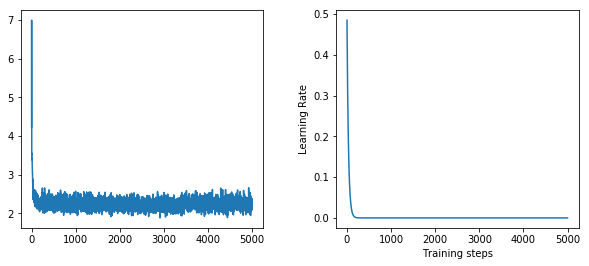

In [99]:
losses = []
learn_rate = []

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    print("Iteration {} ... step {} loss {}".format(step, global_step.eval() , l))
        
    #Monitoring the Model
    losses.append(l)
    learn_rate.append(learning_rate.eval()) #TODO: Get learning rate from model.
    
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))


# Show the loss over time.
fig, (ax1, ax2) = plt.subplots(1, 2)
plt.subplots_adjust(wspace=.3)
fig.set_size_inches(10, 4)
ax1.plot(range(0, num_steps), losses)
ax2.set_ylabel("Loss")
ax2.set_xlabel("Training steps")
#line_x_range = (-4, 6)
ax2.plot(range(0, num_steps), learn_rate)
ax2.set_ylabel("Learning Rate")
ax2.set_xlabel("Training steps")
plt.show()